In [1]:
import os, time
import numpy as np
import pandas as pd
from tqdm import tqdm
from lib import wlanlrz_loader, rtt_matrix_loader, inference_loader
from entities.solver_process import SolverProcess  
from lib.common import disarrange
import powerlaw
import matplotlib.pyplot as plt
import seaborn as sns
import config.hyperparams as hp
import datetime as dt
from multiprocessing import Queue

### WLAN-LRZ AP Data Loader ####
desc = wlanlrz_loader.load_data_description(hp.AP_DESCR)
original_data, coord_dataframe_list, total_ap, original_merged_raw_ap_data = wlanlrz_loader.load_data_parallel(hp.BUILDING, desc, mass_load=False)


Parallel loading of APs data ...
Activating threads now


100%|██████████| 56/56 [00:04<00:00, 12.30it/s]


Total APs: 182
Loading rtt matrix from dataset
Plotting and saving RTT matrix
Starting parallel solvers


/opt/ec_solver/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/ec_solver/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/ec_solver/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/701 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/700 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/700 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/700 [00:00<?, ?it/s]

Starting solver process ...


  0%|          | 0/700 [00:00<?, ?it/s].78it/s]

Starting solver process ...


  0%|          | 1/701 [00:00<01:29,  7.84it/s]

Starting solver process ...


100%|██████████| 701/701 [01:42<00:00,  6.83it/s]


Solver process completed!


100%|██████████| 701/701 [01:44<00:00,  6.69it/s]


Solver process completed!


100%|██████████| 701/701 [02:00<00:00,  5.84it/s]


Solver process completed!


100%|██████████| 701/701 [02:08<00:00,  5.47it/s]


Solver process completed!


100%|██████████| 701/701 [02:25<00:00,  4.81it/s]


Solver process completed!


100%|██████████| 701/701 [02:34<00:00,  4.53it/s]


Solver process completed!


100%|██████████| 701/701 [02:34<00:00,  4.52it/s]


Solver process completed!


100%|██████████| 701/701 [02:39<00:00,  4.41it/s]


Solver process completed!


100%|██████████| 701/701 [02:43<00:00,  4.29it/s]


Solver process completed!


100%|██████████| 701/701 [02:44<00:00,  4.26it/s]


Solver process completed!


100%|██████████| 700/700 [02:45<00:00,  4.22it/s]


Solver process completed!


100%|██████████| 700/700 [03:05<00:00,  3.77it/s]


Solver process completed!


100%|██████████| 700/700 [03:15<00:00,  3.58it/s]


Solver process completed!


100%|██████████| 700/700 [03:16<00:00,  3.57it/s]


Solver process completed!


100%|██████████| 700/700 [03:19<00:00,  3.50it/s]


Solver process completed!


100%|██████████| 701/701 [03:26<00:00,  3.40it/s]


Solver process completed!


100%|██████████| 700/700 [03:29<00:00,  3.34it/s]


Solver process completed!


100%|██████████| 701/701 [03:30<00:00,  3.33it/s]


Solver process completed!


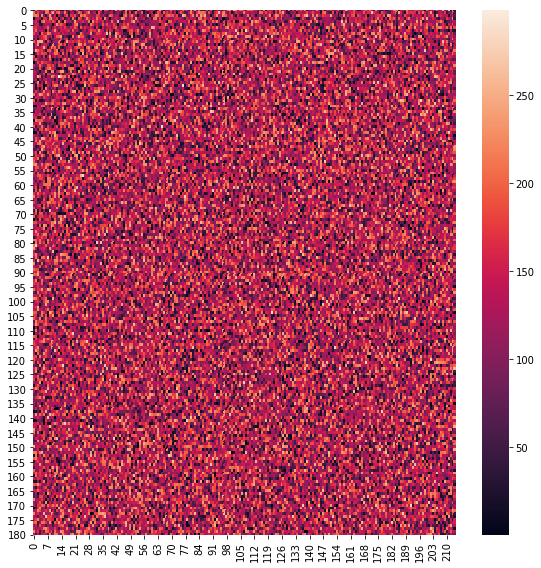

In [2]:
print("Total APs: {}".format(total_ap))
original_data['timestamp'] = original_data.index

# Filter the dataser based on the minimum amount of users we want to serve
data = original_data[original_data.total >= hp.minimum_agents_threshold]
merged_raw_ap_data = original_merged_raw_ap_data[original_merged_raw_ap_data.index.isin(data.index)]
#merged_raw_ap_data = merged_raw_ap_data.loc[:, (merged_raw_ap_data > 0).all()]

#merged_raw_ap_data = merged_raw_ap_data.loc[merged_raw_ap_data.sum(axis=1) >= hp.minimum_agents_threshold]
#merged_raw_ap_data = merged_raw_ap_data.loc[:, (merged_raw_ap_data > 0).all()]

total_ap = len(merged_raw_ap_data.columns)

TOTAL_EPISODES = int(len(data))
TIER_1_EN = total_ap
TIER_2_EN = hp.T2_RATI0
TIER_3_EN = hp.T3_RATI0
EN_RATIO = (TIER_1_EN, TIER_2_EN, TIER_3_EN)
TOTAL_EN = int(TIER_1_EN + TIER_2_EN + TIER_3_EN)

if hp.STORE_RESULTS:
    try:
        os.mkdir(hp.CSV_FOLDER)
    except OSError:
        print ("Creation of the directory %s failed" % hp.CSV_FOLDER)
    else:
        print ("Successfully created the directory %s " % hp.CSV_FOLDER)

if hp.dataset_rtt:
    ### LOAD LATENCY MATRIX FROM DATASET ###
    print("Loading rtt matrix from dataset")
    clf = rtt_matrix_loader.analyze_data(source=hp.dataset_rtt, drange=1000, threshold=250, k=3)
    clf.weights_ = [0.2, 0.2, 0.6]
    rtt_matrix = rtt_matrix_loader.generate_data(clf, n=total_ap, m=TOTAL_EN)
else:
    # Prepare latency matrixes for all the EN classes with increasing latency based on distance from the edge 
    rtt_matrix_en_t1 = np.round(abs(np.random.normal(1, 0.2, (TIER_1_EN, TIER_1_EN))))
    rtt_matrix_en_t2 = np.round(abs(np.random.normal(3, 1, (TIER_1_EN, TIER_2_EN))))
    rtt_matrix_en_t3 = np.round(abs(np.random.normal(10, 1, (TIER_1_EN, TIER_3_EN))))

    sns.distplot(rtt_matrix_en_t1.flatten(), hist=False, rug=True)
    sns.distplot(rtt_matrix_en_t2.flatten(), hist=False, rug=True)
    sns.distplot(rtt_matrix_en_t3.flatten(), hist=False, rug=True)

    rtt_matrix = np.hstack([rtt_matrix_en_t1, rtt_matrix_en_t2, rtt_matrix_en_t3])

#np.random.shuffle(rtt_matrix)
disarrange(rtt_matrix, axis=0)

print("Plotting and saving RTT matrix")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(rtt_matrix, ax=ax)
fig.tight_layout(w_pad=1.5)
fig.savefig("../plots/rtt_matrix.pdf")

# Manually setting latency for colocated AP/EN
for i in range(round(TIER_1_EN/hp.T1_RATIO)):
    rtt_matrix[i][i] = 1
            
data["mean_task_latency"] = np.nan
data["mean_battery_usage"] = np.nan
data["convergence_time"] = np.nan

# Build queues for multithreading
input_queue = Queue(maxsize=0)
result_queue = Queue(maxsize=0)

# Split original dataframes in n chunks
processes = []
data_t = np.array_split(data, hp.parallel_solvers)
merged_raw_ap_data_t = np.array_split(merged_raw_ap_data, hp.parallel_solvers)

print("Starting parallel solvers")
for d, mrad in zip(data_t, merged_raw_ap_data_t):
    input_queue.put(d)
    t = SolverProcess(
        input_queue, result_queue, mrad,
        len(d), TOTAL_EPISODES, EN_RATIO, rtt_matrix,
        TIER_1_EN, TIER_2_EN, TIER_3_EN
        )
    processes.append(t)
    t.start()

dfs = []

# Check if processes are alive (which forces a join() under the hood)
# Extract data from the queue
while 1:
    time.sleep(0.05)
    running = any(p.is_alive() for p in processes)
    while not result_queue.empty():
        s = result_queue.get()
        dfs.append(s)
    if not running:
        break

data = pd.concat(dfs)


/opt/ec_solver/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


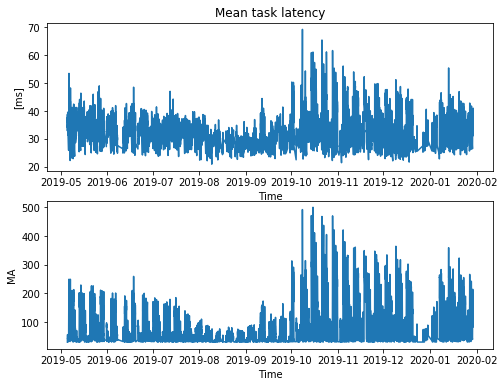

In [3]:
from scipy.interpolate import interp1d


# %%
data.sort_index(inplace=True)
data["datetime"] = pd.to_datetime(data['timestamp'], unit='s')

############# PLOTS: GROUP 1 #############

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# f2 = interp1d(data["datetime"], data["mean_task_latency"], kind='cubic')

### Plot showing the mean task execution time for each agent
sns.lineplot(x="datetime", y="mean_task_latency", data=data, ax=ax[0], dashes=[6, 2])
#s = interp1d(data["datetime"].values.astype(int), data["mean_task_latency"], kind='cubic')
#xnew = np.linspace(data["datetime"].values[0].astype(int), data["datetime"].values[::-1].astype(int), num=len(data["datetime"])*3) 
#sns.lineplot(x="datetime", y=s(xnew), data=data, ax=ax[0], dashes=[6, 2])
ax[0].set(title="Mean task latency", ylabel='[ms]', xlabel='Time')
#ax2 = ax[0].twinx()

#color = 'tab:black'
sns.lineplot(x="datetime", y="total_agents",data=data, ax=ax[1], dashes=True)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('MA')
ax[1].tick_params(axis='y')

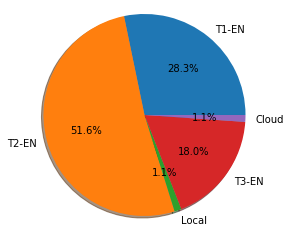

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Pie plot to show the percentage of EN usage for each tier
ta = data["total_agents"].sum()

v1 = np.sum(data["t1-en-load"])/ ta
v2 = np.sum(data["t2-en-load"])/ ta
v3 = np.sum(data["t3-en-load"])/ ta
v4 = data["cloud"].sum() / ta
v5 = data["local"].sum() / ta

ax.pie([v1, v2, v5, v3, v4], labels=['T1-EN','T2-EN','Local','T3-EN','Cloud'], autopct='%1.1f%%', shadow=True)
# ax.set(title="Mobile agents allocation")
ax.axis('equal')

# Saving plots
if hp.save_plots:
    plt.savefig("../plots/full_dataset/ma_allocation.pdf",  bbox_inches="tight")

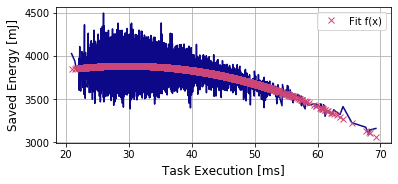

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))

cls = plt.cm.get_cmap("plasma", 3).colors

### Plot showing the correlation between task latency and battery consumption
p = sns.relplot(x="mean_task_latency", y="mean_battery_usage", kind="line", data=data, ax=ax, color=cls[0], legend="full")
# ax.set(title="Correlation between task latency and battery consumption")
ax.set_ylabel("Saved Energy [mJ]").set_fontsize(12)
ax.set_xlabel("Task Execution [ms]").set_fontsize(12)
plt.close(p.fig) # Workaround to eliminate double axis generated by relplot
ax.plot(
    np.unique(data['mean_task_latency']),
    np.poly1d(np.polyfit(data['mean_task_latency'], data['mean_battery_usage'], 3))(np.unique(data['mean_task_latency'])),
    'rx',
    color=cls[1],
    label="Fit f(x)"
)

ax.grid()
ax.legend(ncol=2, loc=1)
# Saving plots
if hp.save_plots:
    plt.savefig("../plots/full_dataset/battery_saving_trend.pdf",  bbox_inches="tight")

/opt/ec_solver/lib/python3.6/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/opt/ec_solver/lib/python3.6/site-packages/seaborn/relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


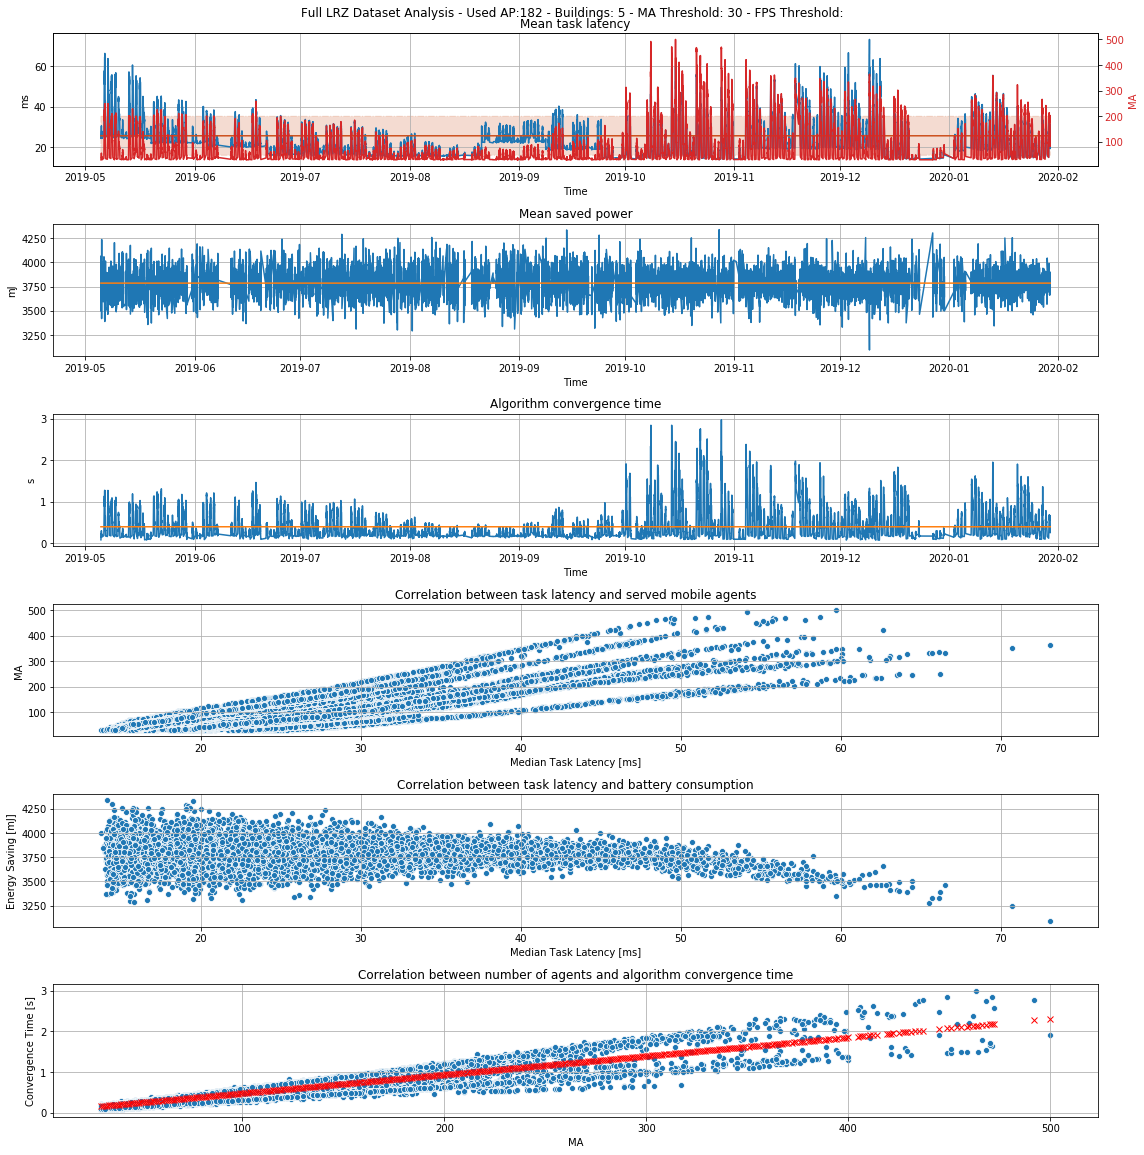

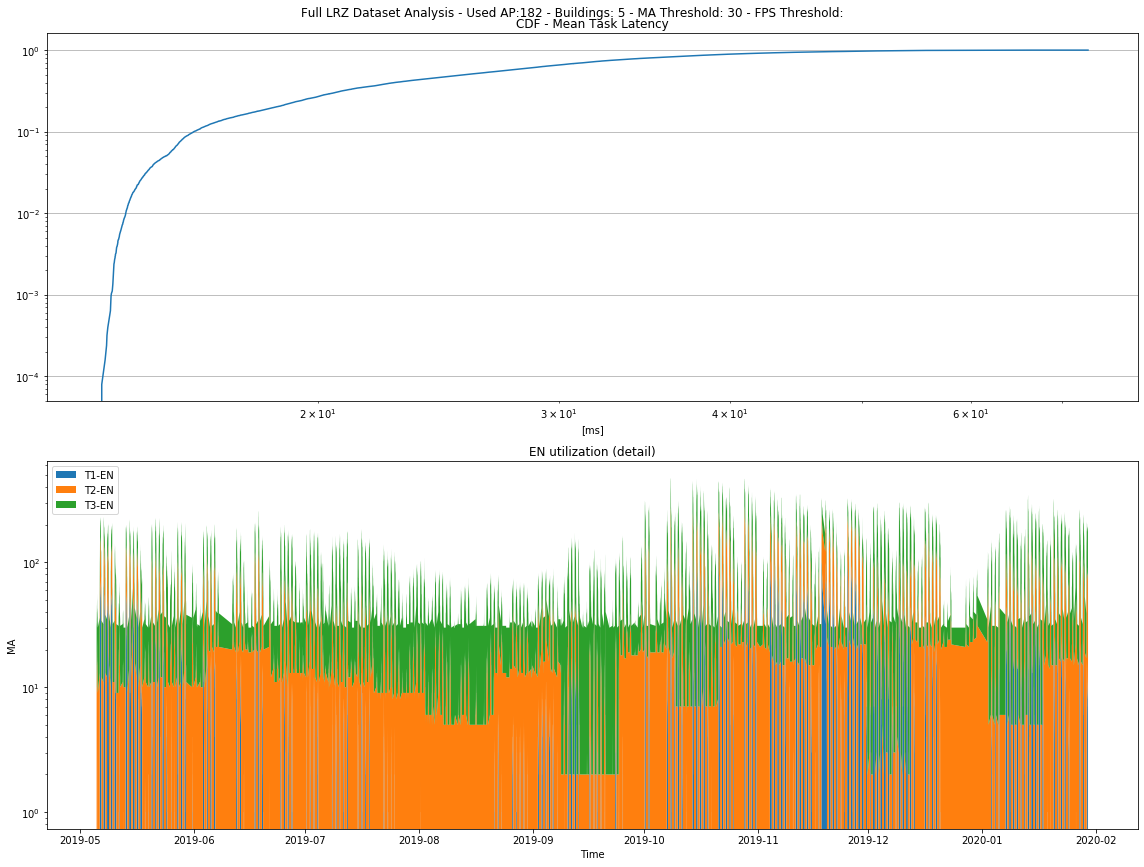

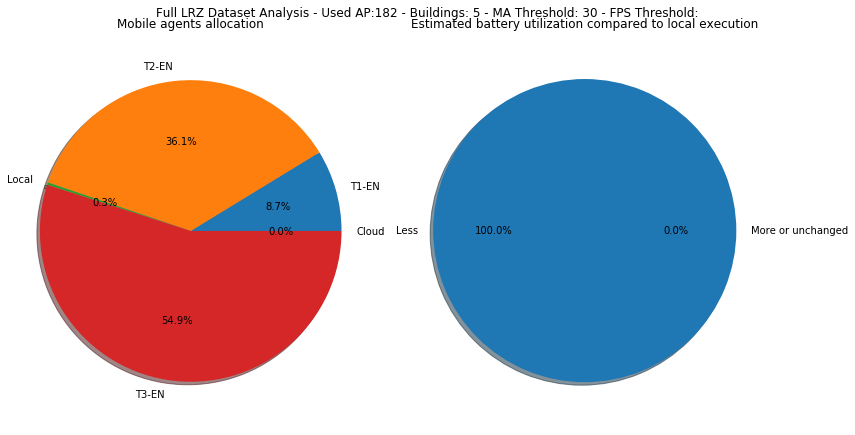

In [39]:
# %%
data.sort_index(inplace=True)
data["datetime"] = pd.to_datetime(data['timestamp'], unit='s')

############# PLOTS: GROUP 1 #############

fig, ax = plt.subplots(6, 1, figsize=(16, 16))

### Plot showing the mean task execution time for each agent
sns.lineplot(x="datetime", y="mean_task_latency", data=data, ax=ax[0], dashes=[6, 2])
sns.lineplot(x="datetime", y=np.median(data["mean_task_latency"]), c='#CC4F1B',data=data, ax=ax[0], dashes=True)
ax[0].fill_between(
    data["datetime"],
    np.median(data["mean_task_latency"])-np.std(data["mean_task_latency"]),
    np.median(data["mean_task_latency"])+np.std(data["mean_task_latency"]),
    alpha=0.2,
    color="#CC4F1B",
    linestyle='dashdot', antialiased=True
    )
ax[0].set(title="Mean task latency", ylabel='ms', xlabel='Time')
ax2 = ax[0].twinx()

color = 'tab:red'
sns.lineplot(x="datetime", y="total_agents", c=color,data=data, ax=ax2, dashes=True)
ax2.set_ylabel('MA', color=color)
ax2.tick_params(axis='y', labelcolor=color)

### Plot showing the mean battery saving for each agent compared to running locally
sns.lineplot(x="datetime", y="mean_battery_usage", data=data, ax=ax[1])
sns.lineplot(x="datetime", y=np.median(data["mean_battery_usage"]), data=data, ax=ax[1], dashes=True)
ax[1].set(title="Mean saved power", ylabel='mJ', xlabel='Time')

### Plot showing algorithm convergence time
sns.lineplot(x="datetime", y="convergence_time", data=data, ax=ax[2])
sns.lineplot(x="datetime", y=np.median(data["convergence_time"]), data=data, ax=ax[2], dashes=True)
ax[2].set(title="Algorithm convergence time", ylabel='s', xlabel='Time')

### Plot showing the correlation berween task latency and served mobile agents
p1 = sns.relplot(x="mean_task_latency", y="total_agents", data=data, ax=ax[3])
ax[3].set(title="Correlation between task latency and served mobile agents")
ax[3].set_xlabel("Median Task Latency [ms]")
ax[3].set_ylabel("MA")
plt.close(p1.fig) # Workaround to eliminate double axis generated by relplot

### Plot showing the correlation between task latency and battery consumption
p2 = sns.relplot(x="mean_task_latency", y="mean_battery_usage", data=data, ax=ax[4])
ax[4].set(title="Correlation between task latency and battery consumption")
ax[4].set_ylabel("Energy Saving [mJ]")
ax[4].set_xlabel("Median Task Latency [ms]")

plt.close(p2.fig) # Workaround to eliminate double axis generated by relplot

### Plot showing the correlation between task latency and battery consumption
p3 = sns.relplot(x="total_agents", y="convergence_time", data=data, ax=ax[5])
ax[5].set(title="Correlation between number of agents and algorithm convergence time")
plt.close(p3.fig) # Workaround to eliminate double axis generated by relplot
ax[5].plot(
    np.unique(data['total_agents']),
    np.poly1d(np.polyfit(data['total_agents'],data['convergence_time'], 1))(np.unique(data['total_agents'])),
    'rx'
    )
ax[5].set_xlabel("MA")
ax[5].set_ylabel("Convergence Time [s]")

for axs in ax:
    axs.grid()

fig.subplots_adjust(hspace=0.2)
fig.suptitle(
    "Full LRZ Dataset Analysis - Used AP:{} - Buildings: {} - MA Threshold: {} - FPS Threshold:"
        .format(total_ap, len(hp.BUILDING), hp.minimum_agents_threshold, hp.FPS), fontsize=12, y=1)
fig.tight_layout()

# Saving plots
if hp.save_plots:
    fig.savefig("../plots/full_dataset/g1_plots.pdf",  bbox_inches="tight")

############# PLOTS: GROUP 2 #############

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
# CDF for task latency
powerlaw.plot_cdf(data=data["mean_task_latency"], ax=ax[0])
ax[0].set(title="CDF - Mean Task Latency")
ax[0].set_xlabel("[ms]")
ax[0].grid()

# Relative load for each tier of edge nodes
ax[1].stackplot(
    data["datetime"].values,
    [data["t1-en-load"].values, data["t2-en-load"].values, data["t3-en-load"].values ],
    labels=['T1-EN','T2-EN','T3-EN']
    )
ax[1].legend(loc='upper left')
ax[1].set(title="EN utilization (detail)")
ax[1].set_yscale("log")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("MA")

fig.subplots_adjust(hspace=0.2)
fig.suptitle(
    "Full LRZ Dataset Analysis - Used AP:{} - Buildings: {} - MA Threshold: {} - FPS Threshold:"
        .format(total_ap, len(hp.BUILDING), hp.minimum_agents_threshold, hp.FPS), fontsize=12, y=1)
fig.tight_layout()

# Saving plots
if hp.save_plots:
    fig.savefig("../plots/full_dataset/g2_plots.pdf",  bbox_inches="tight")

############# PLOTS: GROUP 3 #############

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie plot to show the percentage of EN usage for each tier
ta = data["total_agents"].sum()

v1 = np.sum(data["t1-en-load"])/ ta
v2 = np.sum(data["t2-en-load"])/ ta
v3 = np.sum(data["t3-en-load"])/ ta
v4 = data["cloud"].sum() / ta
v5 = data["local"].sum() / ta

ax[0].pie([v1, v2, v5, v3, v4], labels=['T1-EN','T2-EN','Local','T3-EN','Cloud'], autopct='%1.1f%%', shadow=True)
ax[0].set(title="Mobile agents allocation")
ax[0].axis('equal')

# Pie plot to show the percentage of mobile agents saving battery
pos = len(data[data.mean_battery_usage > 0].mean_battery_usage) / len(data)
neg = len(data[data.mean_battery_usage <= 0].mean_battery_usage) / len(data)

ax[1].pie([pos, neg], labels=['Less','More or unchanged'], autopct='%1.1f%%', shadow=True)
ax[1].set(title="Estimated battery utilization compared to local execution")
ax[1].axis('equal')

fig.subplots_adjust(hspace=0.2)
fig.suptitle(
    "Full LRZ Dataset Analysis - Used AP:{} - Buildings: {} - MA Threshold: {} - FPS Threshold:"
        .format(total_ap, len(hp.BUILDING), hp.minimum_agents_threshold, hp.FPS), fontsize=12, y=1)
fig.tight_layout()

# Saving plots
if hp.save_plots:
    fig.savefig("../plots/full_dataset/g3_plots.pdf",  bbox_inches="tight")


In [8]:
from datetime import datetime
############# HEATMAP PLOT #############

# This doesn't work outside of Jupyter (apart from just saving the map in HTML)
import folium
from folium import plugins

building_users_density_heatmap = folium.Map(
    location=[48.150305,11.580054],
    tiles='stamentoner',
    zoom_start=12,
)

datas = []
flattened = [item for sublist in coord_dataframe_list for item in sublist]
for coord_list in flattened:
    st = coord_list.assign(norm_total=(coord_list.total/coord_list.total.max()))
    st.reset_index(inplace=True)
    datas.append(st[['timestamp', 'latitude', 'longitude', 'total']].values.tolist())

sl = []
for idx, elem in enumerate(datas[0]):
    temp = []
    for i in range(len(datas)):
        try:
            temp.append([datas[i][idx][1], datas[i][idx][2], datas[i][idx][3]])
        except IndexError:
            pass
    sl.append(temp)

dl = list(map(lambda s: datetime.fromtimestamp(s), flattened[0].reset_index().timestamp.tolist()))
    
hmt = plugins.HeatMapWithTime(sl,auto_play=True,use_local_extrema=True, max_opacity=0.8,index=flattened[0].reset_index().timestamp.tolist())
hmt.add_to(building_users_density_heatmap)

# building_users_density_heatmap
building_users_density_heatmap.save('../plots/building_users_density_heatmap.html')


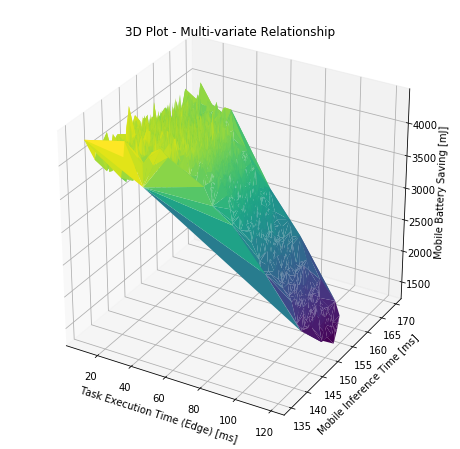

In [9]:
# 3D PLOT
from mpl_toolkits.mplot3d import axes3d, Axes3D 

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.axes(projection="3d")
## LT: this next part is not required, I commented it out
# ax.scatter(data["mean_task_latency"], data["mean_local_inference_time"],
#            data["mean_battery_usage"], c=data["mean_battery_usage"], cmap='viridis')
ax.plot_trisurf(data["mean_task_latency"], data["mean_local_inference_time"],
                data["mean_battery_usage"], cmap='viridis', edgecolor='none')

ax.set_title("3D Plot - Multi-variate Relationship")
ax.set_xlabel('Task Execution Time (Edge) [ms]')
ax.set_ylabel('Mobile Inference Time [ms]')
ax.set_zlabel('Mobile Battery Saving [mJ]')

# Saving plots
if hp.save_plots:
    fig.savefig("../plots/full_dataset/wip/3D_plot.pdf",  bbox_inches="tight")

In [17]:
agg_data = data.assign(mean_task_latency_rounded=lambda x: x.mean_task_latency.apply(np.floor))\
    .assign(mean_local_inference_time_rounded=lambda x: x.mean_local_inference_time.apply(np.floor))\
    .groupby(['mean_task_latency_rounded','mean_local_inference_time_rounded'])\
    .agg({'mean_battery_usage':['mean','std','count']})

In [18]:
agg_data.columns = ['__'.join(v) for v in agg_data.columns]

In [19]:
agg_data.reset_index(inplace=True)

In [20]:
agg_data['mean_battery_usage__sem'] = (agg_data.mean_battery_usage__std /
                                       agg_data.mean_battery_usage__count.apply(np.sqrt))

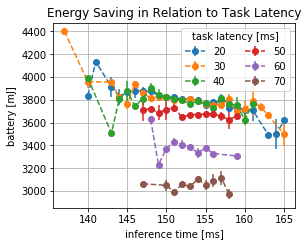

In [170]:
fig,ax = plt.subplots(figsize=(4, 3))

for task_latency in range(20, 71, 10):
    ax.errorbar(x='mean_local_inference_time_rounded',
                y='mean_battery_usage__mean', yerr='mean_battery_usage__sem',
                data=agg_data[agg_data.mean_task_latency_rounded==task_latency], fmt='--o',
                label=task_latency)

ax.legend(ncol=2, title='task latency [ms]')
ax.grid()

ax.set_ylabel('battery [mJ]')
ax.set_xlabel('inference time [ms]')

plt.tight_layout(pad=0)
plt.title("Energy Saving in Relation to Task Latency", fontsize=12, y=1.1)

if hp.save_plots:
    plt.savefig("../plots/full_dataset/wip/battery_locallatency_task.pdf", bbox_inches="tight")

In [22]:
agg_data_max = data.assign(mean_task_latency_rounded=lambda x: x.mean_task_latency.apply(np.floor))\
    .assign(mean_local_inference_time_rounded=lambda x: x.mean_local_inference_time.apply(np.floor))\
    .groupby(['mean_task_latency_rounded','mean_local_inference_time_rounded'])\
    .mean_battery_usage.max().rename('mean_battery_usage__max').reset_index()

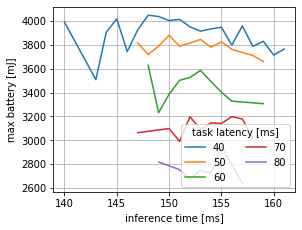

In [23]:
fig,ax = plt.subplots(figsize=(4, 3))

for task_latency in range(40, 81, 10):
    ax.plot(agg_data_max[agg_data_max.mean_task_latency_rounded==task_latency].mean_local_inference_time_rounded,
            agg_data_max[agg_data_max.mean_task_latency_rounded==task_latency].mean_battery_usage__max,
            label=task_latency)

ax.legend(ncol=2, title='task latency [ms]', loc=4)
ax.grid()

ax.set_ylabel('max battery [mJ]')
ax.set_xlabel('inference time [ms]')

plt.tight_layout(pad=0)

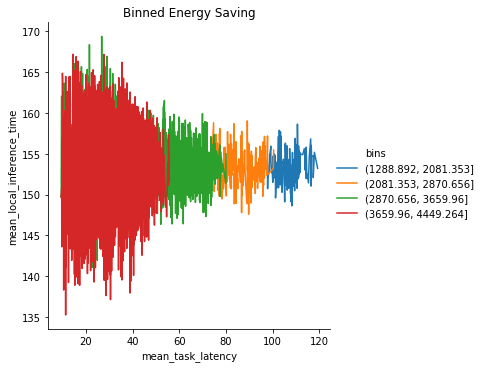

In [10]:
s = pd.cut(data.mean_battery_usage, 4, retbins=False)
data_g = data.assign(bins=s)

p = sns.relplot("mean_task_latency", "mean_local_inference_time", hue="bins", kind='line', data=data_g)
plt.title("Binned Energy Saving")

# Saving plots
if hp.save_plots:
    plt.savefig("../plots/full_dataset/wip/binned_energy_latency.pdf", bbox_inches="tight")
    

In [14]:
x = np.array(data.mean_task_latency)
bins = np.array([30, 40, 50, 60, 70, 80, 90])
binned_edge_node_bw = bins[np.digitize(x,bins,right=True)]

sns.relplot(x="mean_battery_usage", y="mean_local_inference_time",
            hue=binned_edge_node_bw,
            kind="line", data=data)

IndexError: index 7 is out of bounds for axis 0 with size 7

In [291]:
s = pd.cut(data.mean_task_latency, 10, retbins=False)
data_g = data.assign(bins=s)

test = []
for g, d in data_g.groupby(["bins"]):
    test.append((d.mean_task_latency.mean(), d.mean_local_inference_time.mean(), d.mean_battery_usage.mean()))
    
test

[(34.0989155036883, 99.98000405319338, 82.03852161027915),
 (37.82480176285182, 100.04660251245103, 74.09845018149119),
 (43.04187761118709, 100.04240949699904, 73.47884967014924),
 (48.30844117969371, 100.0078375633246, 73.00081993637691),
 (53.4190914478803, 99.98376596998898, 72.86919107197805),
 (58.81132732514434, 99.99045734305707, 72.67295163843768),
 (63.881182521274674, 100.00757217698344, 73.45095968866818),
 (69.02737874207004, 99.98769531268321, 75.74907756860354),
 (74.46153734216385, 100.01812874432409, 79.51393153863809),
 (78.95477741445634, 100.13413046472448, 81.89352303278567)]

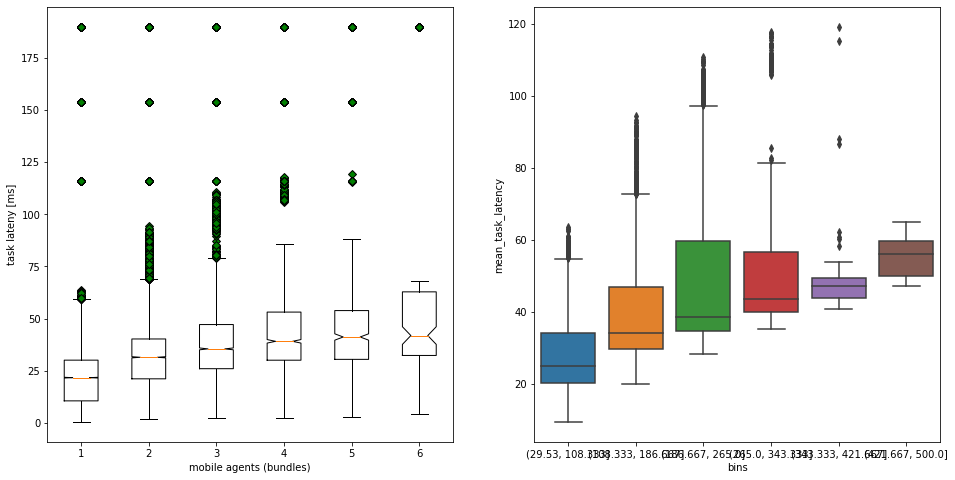

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
s = pd.cut(data.total_agents, 6, retbins=False)
data_g = data.assign(bins=s)


df_l = []
for g,s in data_g.groupby('bins'):
    df = np.concatenate((s["std_task_latency"].values, s["mean_task_latency"].values, s["max_task_latency"].values, s["min_task_latency"].values))
    df_l.append(df)

green_diamond = dict(markerfacecolor='g', marker='D')
ax[0].boxplot(df_l, notch=True, flierprops=green_diamond)
ax[0].set_xlabel("mobile agents (bundles)")
ax[0].set_ylabel("task lateny [ms]")

sns.boxplot(y=data_g["mean_task_latency"], x=data_g['bins'], ax=ax[1])

In [59]:
from pandas import Grouper
from pandas import concat
datat = data
datat.index = pd.to_datetime(datat.index, unit='s')
groups = datat["datetime"].groupby(Grouper(freq='M'))

In [60]:
groups_ml = datat["mean_task_latency"].groupby(Grouper(freq='M'))
groups_ta = datat["total_agents"].groupby(Grouper(freq='M'))

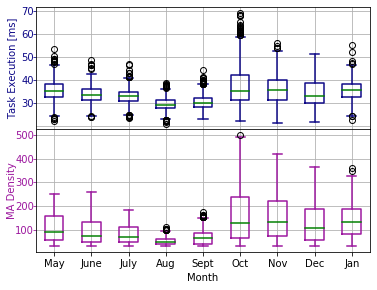

In [159]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4.5))

cls = plt.cm.get_cmap("plasma", 4).colors

months_ml = concat([pd.DataFrame(x[1].values) for x in groups_ml], axis=1)
months_ml = pd.DataFrame(months_ml)
months_ml.columns = range(5,14)

months_ta = concat([pd.DataFrame(x[1].values) for x in groups_ta], axis=1)
months_ta = pd.DataFrame(months_ta)
months_ta.columns = range(5,14)


months_ml.plot(kind='box',
             color=dict(boxes=cls[0], whiskers=cls[0], medians='g', caps=cls[0]),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=0),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, grid=True, rot=0, ax=ax[0])

# ax[0] = months_ml.boxplot()
ax[0].set_ylabel("Task Execution [ms]")
ax[0].set_xticks(range(1,10), ("May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec", "Jan"))

ax[0].yaxis.label.set_color(cls[0])
ax[0].tick_params(axis='y', colors=cls[0], pad=-2)

months_ta.plot(kind='box',
             color=dict(boxes=cls[1], whiskers=cls[1], medians='g', caps=cls[1]),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=0),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, grid=True, rot=0, ax=ax[1])

ax[1].set_ylabel("MA Density", labelpad=-2)
ax[1].set_xlabel("Month")

ax[1].yaxis.label.set_color(cls[1])
ax[1].tick_params(axis='y', colors=cls[1], pad=-2)

plt.subplots_adjust(hspace=.0)

plt.setp(ax[0].get_xticklabels(), visible=False)
# remove last tick label for the second subplot
# yticks = ax[1].yaxis.get_major_ticks()
# yticks[5].label1.set_visible(False)

yticks = ax[0].yaxis.get_major_ticks()
yticks[1].label1.set_visible(False)
yticks[1].tick1line.set_visible(False)

plt.xticks(range(1,10), ("May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec", "Jan"))

# Saving plots
if hp.save_plots:
    plt.savefig("../plots/full_dataset/time_series_boxplot.pdf")

# added plots

In [183]:
## This will change the style of the plots a bit
import matplotlib

plt.style.use('classic')

matplotlib.rcParams['axes.facecolor'] = 'w'
matplotlib.rcParams['axes.edgecolor'] = 'k'
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10
matplotlib.rcParams['lines.color'] = 'xkcd:blue'
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20

width = 7
height = width / 1.618

# Use matplotlib fonts
matplotlib.rcParams['text.usetex']=True

In [180]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


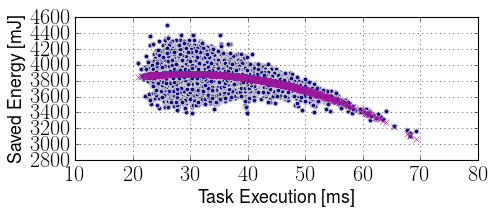

In [279]:
fig,ax = plt.subplots(figsize=(6, 2.5))

data.plot.scatter('mean_task_latency',
                  'mean_battery_usage', ax=ax,
                  c=cls[0], edgecolor='lightgrey')

ax.set_ylabel("Saved Energy [mJ]", fontsize=16)
ax.set_xlabel("Task Execution [ms]", fontsize=16)

ax.plot(
    np.unique(data['mean_task_latency']),
    np.poly1d(np.polyfit(data['mean_task_latency'], data['mean_battery_usage'], 3))(np.unique(data['mean_task_latency'])),
    'rx',
    color=cls[1],
    label="Fit f(x)",
    markersize=5
)

ax.legend().set_visible(False)
ax.grid()

plt.tight_layout(pad=0)

# Saving plots
if hp.save_plots:
    plt.savefig("../plots/full_dataset/battery_saving_trend.pdf",  bbox_inches="tight")

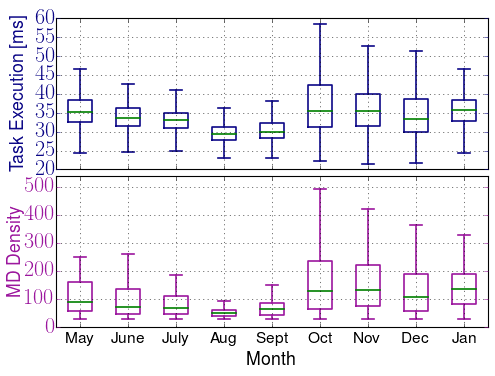

In [280]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4.5))

cls = plt.cm.get_cmap("plasma", 4).colors

months_ml = concat([pd.DataFrame(x[1].values) for x in groups_ml], axis=1)
months_ml = pd.DataFrame(months_ml)
months_ml.columns = range(5,14)

months_ta = concat([pd.DataFrame(x[1].values) for x in groups_ta], axis=1)
months_ta = pd.DataFrame(months_ta)
months_ta.columns = range(5,14)


months_ml.plot(kind='box',
             color=dict(boxes=cls[0], whiskers=cls[0], medians='g', caps=cls[0]),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=0),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True, rot=0, ax=ax[0])

# ax[0] = months_ml.boxplot()
ax[0].set_ylabel("Task Execution [ms]", fontsize=16, labelpad=6)
ax[0].set_xticks(range(1,10), ("May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec", "Jan"))

ax[0].yaxis.label.set_color(cls[0])
ax[0].tick_params(axis='y', colors=cls[0], pad=1)
ax[0].set_ylim(20,60)

months_ta.plot(kind='box',
             color=dict(boxes=cls[1], whiskers=cls[1], medians='g', caps=cls[1]),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=0),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True, rot=0, ax=ax[1])

ax[1].set_ylabel("MD Density", fontsize=16, labelpad=0)
ax[1].set_xlabel("Month", fontsize=16)

ax[1].yaxis.label.set_color(cls[1])
ax[1].tick_params(axis='y', colors=cls[1], pad=1)
ax[1].set_ylim(0,540)

plt.subplots_adjust(hspace=.0)

plt.setp(ax[0].get_xticklabels(), visible=False)
# remove last tick label for the second subplot
# yticks = ax[1].yaxis.get_major_ticks()
# yticks[5].label1.set_visible(False)

yticks = ax[0].yaxis.get_major_ticks()
#yticks[0].label1.set_visible(False)
yticks[1].tick1line.set_visible(False)

plt.xticks(range(1,10), ("May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec", "Jan"),
           fontsize=14)

plt.tight_layout(pad=0, h_pad=-0.3)


if hp.save_plots:
    plt.savefig("../plots/full_dataset/time_series_boxplot.pdf")